In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import numpy as np
import tensorflow as tf
import os
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0,4.0)

pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


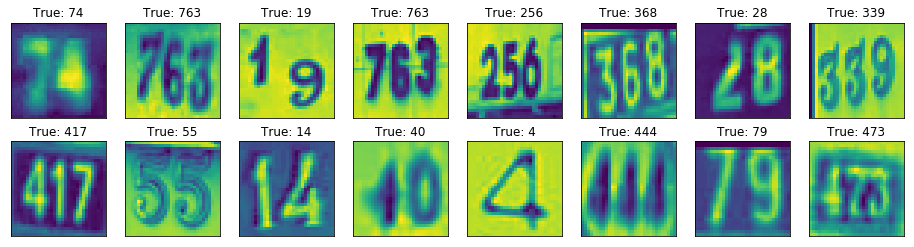

In [5]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i][1:] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(train_dataset, 2, 8, train_labels)

In [6]:
def digit_count(labels):
    counts = []
    for num_digits in range(6):
        count = 0
        for l in labels:
            if np.sum(l != 10) == num_digits:
                count += 1
        counts.append(count)
    last = 0
    for l in labels:
        if l[4] == 10:
            last += 1      
    print ("Labels: ", len(labels))
    print ("Blank: ", counts[0], 
           " One: ", counts[1], 
           " Two: ", counts[2], 
           " Three: ", counts[3], 
           " Four: ", counts[4], 
           " Five: ", counts[5])
    print ("Total: ", np.sum(counts[i] for i in range(len(counts))))
    print ("Last Digit is not 10: ", len(labels)-last)
    return counts

train_count = digit_count(train_labels[:,1:])
valid_count = digit_count(valid_labels[:,1:])
test_count = digit_count(test_labels[:,1:])

def classifier_penalty_weights(t_count, v_count):
    totals = []
    for i in range(1,len(t_count)):
        totals.append(t_count[i]+v_count[i])
    num = np.sum(totals[i] for i in range(len(totals)))
    print (" One: ", totals[0], 
           " Two: ", totals[1], 
           " Three: ", totals[2], 
           " Four: ", totals[3], 
           " Five: ", totals[4])
    print ("Total: ", num)
    weights = []
    for i in range(len(totals)):
        weights.append(num/totals[i])
    norm = np.sum(weights[i] for i in range(len(weights)))
    result = []
    for i in range(len(weights)):
        result.append(1.0* weights[i] / norm)
    print (result)
    return result

penalty_weights = classifier_penalty_weights(train_count, valid_count)

def cumul_counts(tr, v, te):
    result = []
    for i in range(1,len(tr)):
        result.append(tr[i] + v[i] + te[i])
    return result

cumulative_count = cumul_counts(train_count, valid_count, test_count)



Labels:  230070
Blank:  0  One:  13534  Two:  86866  Three:  113935  Four:  15613  Five:  122
Total:  230070
Last Digit is not 10:  122
Labels:  5684
Blank:  0  One:  988  Two:  2990  Three:  1545  Four:  159  Five:  2
Total:  5684
Last Digit is not 10:  2
Labels:  13068
Blank:  0  One:  2483  Two:  8356  Three:  2081  Four:  146  Five:  2
Total:  13068
Last Digit is not 10:  2
 One:  14522  Two:  89856  Three:  115480  Four:  15772  Five:  124
Total:  235754
[0.0083807532859904, 0.0013544482195863667, 0.0010539080292617992, 0.007716541923608457, 0.981494348541553]


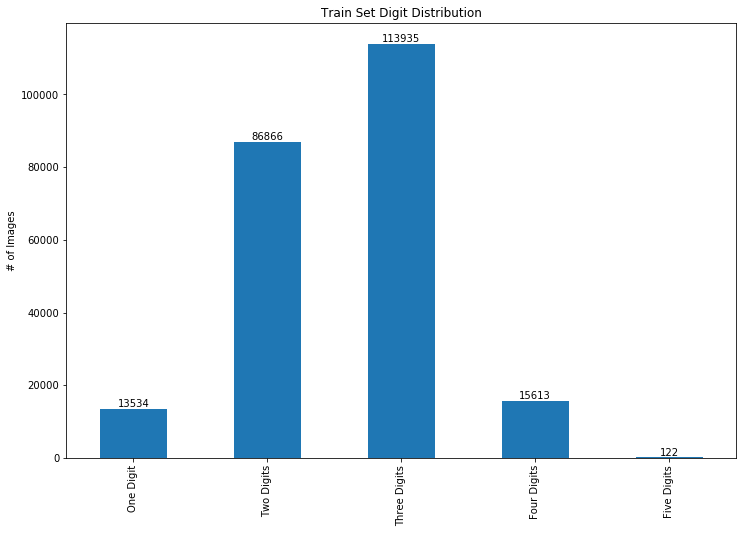

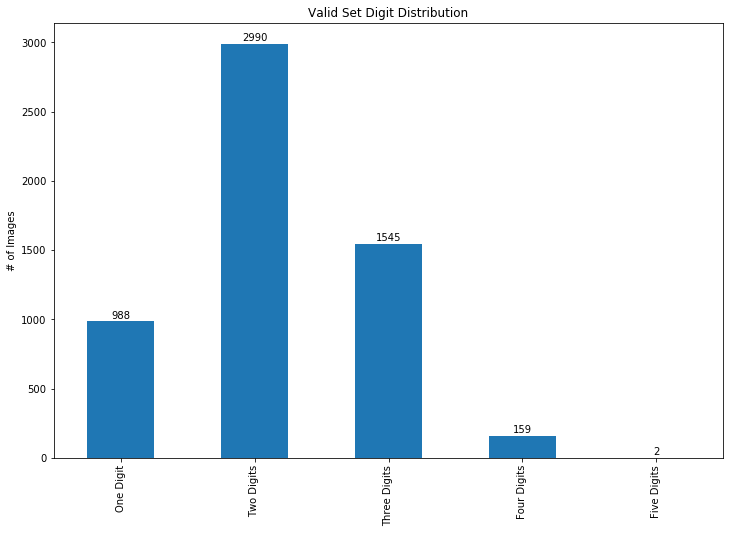

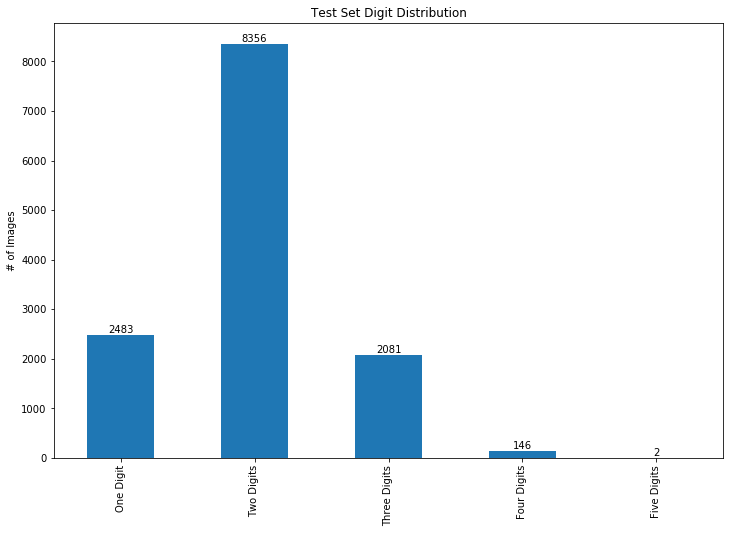

In [7]:
import pandas as pd

frequencies = train_count[1:]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['One Digit','Two Digits','Three Digits', 'Four Digits', 'Five Digits']
plt.figure(figsize=(12,8))
ax = freq_series.plot(kind='bar')
ax.set_title('Train Set Digit Distribution')
ax.set_ylabel('# of Images')
ax.set_xticklabels(x_labels)

rects = ax.patches

labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

frequencies = valid_count[1:]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['One Digit','Two Digits','Three Digits', 'Four Digits', 'Five Digits']
plt.figure(figsize=(12,8))
ax = freq_series.plot(kind='bar')
ax.set_title('Valid Set Digit Distribution')
ax.set_ylabel('# of Images')
ax.set_xticklabels(x_labels)

rects = ax.patches

labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

frequencies = test_count[1:]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['One Digit','Two Digits','Three Digits', 'Four Digits', 'Five Digits']
plt.figure(figsize=(12,8))
ax = freq_series.plot(kind='bar')
ax.set_title('Test Set Digit Distribution')
ax.set_ylabel('# of Images')
ax.set_xticklabels(x_labels)

rects = ax.patches

labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

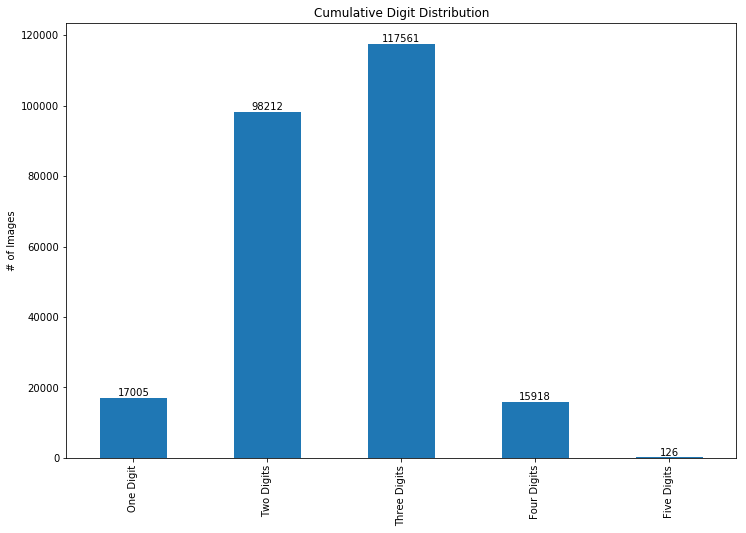

In [8]:
frequencies = cumulative_count
freq_series = pd.Series.from_array(frequencies)

x_labels = ['One Digit','Two Digits','Three Digits', 'Four Digits', 'Five Digits']
plt.figure(figsize=(12,8))
ax = freq_series.plot(kind='bar')
ax.set_title('Cumulative Digit Distribution')
ax.set_ylabel('# of Images')
ax.set_xticklabels(x_labels)

rects = ax.patches

labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [9]:
image_size = 32
num_labels = 11
num_channels = 1

sess = tf.InteractiveSession()

x_image = tf.placeholder(tf.float32, shape=(None, 32, 32, 1), name="x_image")
y = tf.placeholder(tf.int64, shape=(None, 6), name="y")

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_1x1(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 1, 1, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 48])
b_conv1 = bias_variable([48])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 48, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_1x1(h_conv2)

W_fc1 = weight_variable([16384, 3072])
b_fc1 = bias_variable([3072])

h_pool2_flat = tf.contrib.layers.flatten(h_pool2)
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_1 = weight_variable([3072, 11])
b_1 = bias_variable([11])
W_2 = weight_variable([3072, 11])
b_2 = bias_variable([11])
W_3 = weight_variable([3072, 11])
b_3 = bias_variable([11])
W_4 = weight_variable([3072, 11])
b_4 = bias_variable([11])
W_5 = weight_variable([3072, 11])
b_5 = bias_variable([11])

y_1 = tf.matmul(h_fc1_drop, W_1) + b_1
y_2 = tf.matmul(h_fc1_drop, W_2) + b_2
y_3 = tf.matmul(h_fc1_drop, W_3) + b_3
y_4 = tf.matmul(h_fc1_drop, W_4) + b_4
y_5 = tf.matmul(h_fc1_drop, W_5) + b_5

y_pred = tf.stack([y_1,y_2,y_3,y_4,y_5])

y_pred_class = tf.transpose(tf.argmax(y_pred, dimension=2))
y_pred_class = tf.identity(y_pred_class, name='y_pred_class')

Initialized
step 0, Batch accuracy 0
Valid accuracy 0
step 100, Batch accuracy 0.015625
Valid accuracy 0.00510204
step 200, Batch accuracy 0.015625
Valid accuracy 0.0075651
step 300, Batch accuracy 0
Valid accuracy 0.0105559
step 400, Batch accuracy 0
Valid accuracy 0.0179451
step 500, Batch accuracy 0.0234375
Valid accuracy 0.0253343
step 600, Batch accuracy 0.03125
Valid accuracy 0.0270936
step 700, Batch accuracy 0.0234375
Valid accuracy 0.0381773
step 800, Batch accuracy 0.046875
Valid accuracy 0.0413441
step 900, Batch accuracy 0.0390625
Valid accuracy 0.0492611
step 1000, Batch accuracy 0.078125
Valid accuracy 0.0606967
step 1100, Batch accuracy 0.0625
Valid accuracy 0.0694933
step 1200, Batch accuracy 0.0859375
Valid accuracy 0.0770584
step 1300, Batch accuracy 0.0703125
Valid accuracy 0.0791696
step 1400, Batch accuracy 0.0703125
Valid accuracy 0.0893737
step 1500, Batch accuracy 0.0859375
Valid accuracy 0.0941239
step 1600, Batch accuracy 0.109375
Valid accuracy 0.0934201
step

step 13900, Batch accuracy 0.609375
Valid accuracy 0.584799
step 14000, Batch accuracy 0.6875
Valid accuracy 0.591485
step 14100, Batch accuracy 0.625
Valid accuracy 0.549261
step 14200, Batch accuracy 0.539062
Valid accuracy 0.577058
step 14300, Batch accuracy 0.632812
Valid accuracy 0.590253
step 14400, Batch accuracy 0.585938
Valid accuracy 0.595531
step 14500, Batch accuracy 0.625
Valid accuracy 0.593948
step 14600, Batch accuracy 0.648438
Valid accuracy 0.608902
step 14700, Batch accuracy 0.640625
Valid accuracy 0.606263
step 14800, Batch accuracy 0.679688
Valid accuracy 0.611893
step 14900, Batch accuracy 0.59375
Valid accuracy 0.593068
step 15000, Batch accuracy 0.554688
Valid accuracy 0.569493
step 15100, Batch accuracy 0.601562
Valid accuracy 0.604856
step 15200, Batch accuracy 0.59375
Valid accuracy 0.599754
step 15300, Batch accuracy 0.625
Valid accuracy 0.612949
step 15400, Batch accuracy 0.6875
Valid accuracy 0.615939
step 15500, Batch accuracy 0.65625
Valid accuracy 0.615

Valid accuracy 0.697044
step 27800, Batch accuracy 0.84375
Valid accuracy 0.730647
step 27900, Batch accuracy 0.804688
Valid accuracy 0.713758
step 28000, Batch accuracy 0.734375
Valid accuracy 0.699331
step 28100, Batch accuracy 0.820312
Valid accuracy 0.717277
step 28200, Batch accuracy 0.8125
Valid accuracy 0.704785
step 28300, Batch accuracy 0.851562
Valid accuracy 0.726953
step 28400, Batch accuracy 0.84375
Valid accuracy 0.728008
step 28500, Batch accuracy 0.859375
Valid accuracy 0.727129
step 28600, Batch accuracy 0.8125
Valid accuracy 0.727832
step 28700, Batch accuracy 0.820312
Valid accuracy 0.728888
step 28800, Batch accuracy 0.8125
Valid accuracy 0.73399
step 28900, Batch accuracy 0.882812
Valid accuracy 0.73311
step 29000, Batch accuracy 0.8125
Valid accuracy 0.735398
step 29100, Batch accuracy 0.851562
Valid accuracy 0.727481
step 29200, Batch accuracy 0.859375
Valid accuracy 0.731527
step 29300, Batch accuracy 0.859375
Valid accuracy 0.730999
step 29400, Batch accuracy 0

step 41600, Batch accuracy 0.953125
Valid accuracy 0.767945
step 41700, Batch accuracy 0.921875
Valid accuracy 0.764426
step 41800, Batch accuracy 0.898438
Valid accuracy 0.76601
step 41900, Batch accuracy 0.9375
Valid accuracy 0.768825
step 42000, Batch accuracy 0.921875
Valid accuracy 0.769529
step 42100, Batch accuracy 0.898438
Valid accuracy 0.770408
step 42200, Batch accuracy 0.882812
Valid accuracy 0.777094
step 42300, Batch accuracy 0.929688
Valid accuracy 0.764602
step 42400, Batch accuracy 0.882812
Valid accuracy 0.770584
step 42500, Batch accuracy 0.890625
Valid accuracy 0.769177
step 42600, Batch accuracy 0.960938
Valid accuracy 0.770584
step 42700, Batch accuracy 0.945312
Valid accuracy 0.770584
step 42800, Batch accuracy 0.984375
Valid accuracy 0.77164
step 42900, Batch accuracy 0.945312
Valid accuracy 0.773927
step 43000, Batch accuracy 0.890625
Valid accuracy 0.772343
step 43100, Batch accuracy 0.929688
Valid accuracy 0.771816
step 43200, Batch accuracy 0.9375
Valid accu

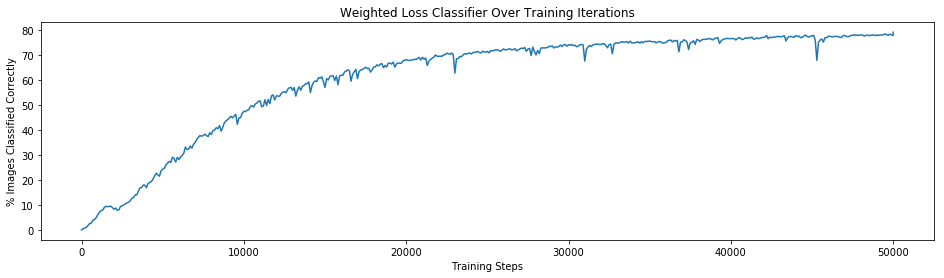

In [10]:
batch_size=128
cross_entropy = tf.reduce_mean(penalty_weights[0] * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y[:,1], logits=y_1) +
                              penalty_weights [1] * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y[:,2], logits=y_2) +
                              penalty_weights [2] * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y[:,3], logits=y_3) +
                              penalty_weights [3] * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y[:,4], logits=y_4) +
                              penalty_weights [4] * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y[:,5], logits=y_5))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_predictions = tf.reduce_min(tf.cast(tf.equal(y_pred_class,y[:,1:]), tf.float32),1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")
sess.run(tf.global_variables_initializer())
print('Initialized')
accuracy_curve = []
for step in range(50001):
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    if step%100 == 0:
        acc = sess.run(accuracy,feed_dict={x_image : batch_data, y : batch_labels, keep_prob : 1.0})
        print("step %d, Batch accuracy %g"%(step, acc))
        acc = sess.run(accuracy,feed_dict={x_image : valid_dataset, y : valid_labels, keep_prob : 1.0}) 
        print("Valid accuracy %g"%acc)
        accuracy_curve.append((step,100.0*acc))
    train_step.run(feed_dict={x_image: batch_data, y : batch_labels, keep_prob: 0.5})
acc = sess.run(accuracy,feed_dict={x_image : test_dataset, y : test_labels, keep_prob : 1.0}) 
print("Test accuracy %g"%acc)
accuracy_curve.append((50001,100.0*acc))
save_model_path = './multi_digit_classification_weighted'
# Save Model
saver = tf.train.Saver()
save_path = saver.save(sess, save_model_path)

plt.plot(*zip(*accuracy_curve))
plt.title('Weighted Loss Classifier Over Training Iterations')
plt.xlabel('Training Steps')
plt.ylabel('% Images Classified Correctly')
plt.show()

In [6]:
import tensorflow as tf
import pickle
import random

# Set batch size if not already set
save_model_path = './multi_digit_classification_weighted'

def test_model():
    """
    Test the saved model against the test dataset
    """

    pickle_file = 'google_images.pickle'

    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        gtest_features = save['real_test_dataset']
        gtest_labels = save['real_test_labels']
        del save  # hint to help gc free up memory
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x_image:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('y_pred_class:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Check accuracy in predicting images taken from Google images
        test_batch_acc_total, predictions = sess.run(
                [loaded_acc,loaded_logits],
                feed_dict={loaded_x: gtest_features, loaded_y: gtest_labels, loaded_keep_prob: 1.0})

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total))
        for i in range(len(predictions)):
            print('Predicted: ',predictions[i],' Actual: ',gtest_labels[i][1:])
            
        predictions = sess.run(loaded_logits, 
                               feed_dict={loaded_x : test_dataset, loaded_y : test_labels, loaded_keep_prob : 1.0})
        
        blanks = 0
        for pred in predictions:
            if pred[4] == 10:
                blanks += 1
        print('Percentage of digit 5 predicted blank: ', 100.0 * blanks/test_labels.shape[0])


test_model()

INFO:tensorflow:Restoring parameters from ./multi_digit_classification_weighted
Testing Accuracy: 0.30000001192092896

Predicted:  [ 1  2  8 10 10]  Actual:  [6, 2, 3, 9, 5]
Predicted:  [ 5 10 10 10 10]  Actual:  [5, 10, 10, 10, 10]
Predicted:  [ 2  4  1 10 10]  Actual:  [6, 3, 4, 1, 9]
Predicted:  [ 5  4  4 10 10]  Actual:  [1, 4, 0, 4, 1]
Predicted:  [ 5 10 10 10 10]  Actual:  [5, 10, 10, 10, 10]
Predicted:  [ 1  2  8 10 10]  Actual:  [1, 5, 5, 9, 5]
Predicted:  [ 5  5 10 10 10]  Actual:  [5, 5, 10, 10, 10]
Predicted:  [ 1  2  3 10 10]  Actual:  [1, 2, 3, 10, 10]
Predicted:  [ 7  0  5 10 10]  Actual:  [7, 0, 5, 10, 10]
Predicted:  [ 6  3  9 10 10]  Actual:  [1, 3, 3, 3, 0]
Predicted:  [ 1  5 10 10 10]  Actual:  [1, 5, 10, 10, 10]
Predicted:  [ 5  5  7 10 10]  Actual:  [1, 9, 1, 7, 7]
Predicted:  [ 2  1  8 10 10]  Actual:  [7, 1, 8, 10, 10]
Predicted:  [ 4  6  0 10 10]  Actual:  [1, 4, 6, 6, 4]
Predicted:  [ 1  0  2 10 10]  Actual:  [1, 2, 5, 5, 7]
Predicted:  [ 5  5  4 10 10]  Actual